# Business Context

Cardio Catch Disease is a company specialized in detecting cardiac diseases at early stages.

- **Business Model:** The price of the diagnosis varies according to the accuracy achieved by the team of specialists, the client pays R$500 for each 5% accuracy above 50%.


- **Actual Scenario:** The current diagnostic accuracy varies between 55% and 65%, due to the complexity of the diagnosis, at a cost of R$1000.


- **Main Goal:** Create a disease diagnosis tool with stable accuracy. 


- **Secundary Goals:** Delivery a report ansewirng the follow questions:
    1. How accurate and precise is the tool?
    2. How much profit Cardio Catch Diseases will make with the new tool?
    3. How reliable are the results given by the new tool?
    

Business Project reference: https://sejaumdatascientist.com/projeto-de-data-science-diagnostico-precoce-de-doencas-cardiovasculares/

Data Source: https://www.kaggle.com/sulianova/cardiovascular-disease-dataset

# 0.0. Imports

In [1]:
# data manipulation
import numpy as np
import pandas as pd

# statistics
from scipy.stats import chi2_contingency, pointbiserialr

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# load images
from IPython.display import Image

# stratified sampling
from sklearn import model_selection as ms

# data preparation
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder

# save objects
import pickle

# feature selection
from boruta import BorutaPy
from sklearn import decomposition

# machine learning models
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, roc_curve
from sklearn.model_selection import cross_val_score, cross_validate

# filter warnings
import warnings
warnings.filterwarnings('ignore')

## 0.1. Auxiliar Functions

In [2]:
def cramer_v(x, y):
    # simple cross tabulation
    cm = pd.crosstab(x, y).values
    
    # number of observations
    n = cm.sum()
    
    # number of rows and columns
    r, k = cm.shape
    
    # phi coefficient
    chi2 = chi2_contingency(cm)[0]
    
    # correction of phi coefficient
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    # number of rows and columns correction
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))

## 0.2. Load Data

In [3]:
data_raw = pd.read_csv('../datasets/cardio_train.csv', sep=';')

## 0.3. Split Data into Train and Test

In [4]:
data_train, data_test = ms.train_test_split(data_raw, test_size=0.2, random_state=42)

# 1.0. Data Description

In [5]:
df01 = data_train.copy()

**age:** Age in days

**height:** Height in cm

**weight:** Weight in kg

**gender:** Gender

**ap_hi:** Systolic blood pressure

**ap_lo:** Diastolic blood pressure

**cholesterol:** Cholesterol (1: normal, 2: above normal, 3: well above normal)

**gluc** Glucose (1: normal, 2: above normal, 3: well above normal)

**smoke:** Smoking

**alco:** Alcohol intake

**active:** Physical activity

**cardio:** Presence or absence of cardiovascular disease (Target Variable)

## 1.1. Data Types

In [6]:
df01.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

## 1.2. Data Dimensions

In [7]:
print(f'Number of rows: {df01.shape[0]}')
print(f'Number of columns: {df01.shape[1]}')

Number of rows: 56000
Number of columns: 13


## 1.3. Check NA

In [8]:
df01.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

## 1.4. Fillout NA
There is no NA in the dataset

## 1.5. Change Data Type

In [9]:
# convert age to years
df01['age'] = np.round(df01['age']/365, 2)

# convert gender to binary 
df01['gender'] = df01['gender'] - 1

## 1.6. Check Balance Data

In [10]:
df01['cardio'].value_counts(normalize=True)

0    0.500589
1    0.499411
Name: cardio, dtype: float64

 - Dataset with the two categories well balanced with approximately 50% for both classes

## 1.7. Descriptive Analysis

In [11]:
# select numeric attributes
num_attributes = df01[['age', 'height', 'weight', 'ap_hi', 'ap_lo']]

# select categoric attributes (include binary and status attributes)
cat_attributes = df01[['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']]

### 1.7.1. Numerical Attributes

In [12]:
# central tendency - mean, median
mean = pd.DataFrame(num_attributes.apply(np.mean)).T
median = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
std = pd.DataFrame(num_attributes.apply(np.std)).T
min_ = pd.DataFrame(num_attributes.apply(min)).T
max_ = pd.DataFrame(num_attributes.apply(max)).T
range_ = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# join dataframes
num_stats = pd.concat([min_, max_, range_, mean, median, skew, kurtosis]).T.reset_index()
num_stats.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'skew', 'kurtosis']

# display numerical analysis
num_stats

,attributes,min,max,range,mean,median,skew,kurtosis
0,age,29.58,64.97,35.39,53.328568,53.97,-0.305527,-0.823468
1,height,55.00,250.00,195.00,164.348125,165.00,-0.594831,7.616794
2,weight,22.00,200.00,178.00,74.188586,72.00,1.015661,2.630229
3,ap_hi,-140.00,14020.00,14160.00,128.737893,120.00,85.641414,7642.334178
4,ap_lo,0.00,11000.00,11000.00,97.025536,80.00,31.969044,1369.195570


- The lowest height (55 cm) and the highest height (250 cm) seem incorrect;
- Minimum weight (22kg) seems incorrect considering the youngest patient is 29 years old;
- Negative systolic pressure seems incorrect;
- Systolic and diastolic pressures with exobirtant maximum values seem incorrect;

### 1.7.2. Categorical Attributes

In [13]:
cat_attributes.astype('object').describe()

,gender,cholesterol,gluc,smoke,alco,active,cardio
count,56000,56000,56000,56000,56000,56000,56000
unique,2,3,3,2,2,2,2
top,0,1,1,0,0,1,0
freq,36401,41910,47619,51030,52929,45011,28033


- 65.00% of patients are of one gender;
- 91.13% of patients are non-smokers;
- 94.52% of patients do not drink alcohol:;
- 80.38% of patients practice pshysical activity;

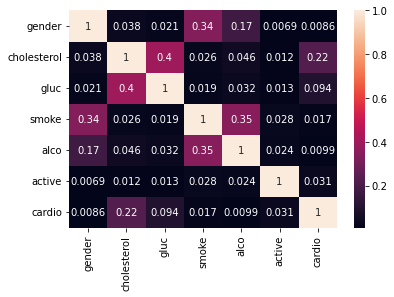

In [14]:
cat_columns = cat_attributes.columns.tolist()

corr_dict = {}

for main_cols in cat_columns:
    corr_list = []
    
    for secundary_cols in cat_columns:
        #cramer v
        cat_corr = cramer_v(cat_attributes[main_cols], cat_attributes[secundary_cols])
        
        # add to list
        corr_list.append(cat_corr)
    
    # add to dict each attribute correlation
    corr_dict[main_cols] = corr_list
    
df_corr = pd.DataFrame(corr_dict)
df_corr = df_corr.set_index(df_corr.columns)
sns.heatmap(df_corr, annot=True);

# 2.0. Feature Engineering

In [15]:
df02 = df01.copy()

## 2.1. Mental Map of Hypothesis

In [16]:
Image('../images/CARDIO_CATCH_DESEASE.png')

FileNotFoundError: No such file or directory: '../images/CARDIO_CATCH_DESEASE.png'

FileNotFoundError: No such file or directory: '../images/CARDIO_CATCH_DESEASE.png'

<IPython.core.display.Image object>

## 2.2. Hypothesis Creation

### 2.2.1. Objective Features Hypotheses

1. Both genders have the same proportion of cardiovascular diseases.

2. People over 40 have more than twice as many cardiovascular diseases, on average.

3. The higher the weight/height ratio, the greater the amount of cardiovascular disease.

4. Between 40% and 50% of people over 100kg have cardiovascular disease.

5. People with heights below 150cm have half as many cardiovascular diseases on average.

### 2.2.2. Examination Features Hypotheses

1. People with cholesterol well above normal are twice as likely to have cardiovascular disease, on average.

2. Less than 25% of people with normal cholesterol and glucose have cardiovascular disease.

3. People with all three glucose levels have a similar percentage (+/-5%) of cardiovascular disease.

4. People with systolic blood pressure above 120 mmHg have 50% more cardiovascular diseases compared to those with pressure below 120 mmHg.

5. People with a diastolic pressure above 80 mmHg have 50% more cardiovascular diseases compared to those with a pressure below 80 mmHg. 

6. People with blood pressure (ap_hi / api_lo) higher than 2 have 30% more cardiovascular diseases than those with pressure below. 


### 2.2.3. Subjective Features Hypotheses

1. People who drink have 20% less cardiovascular disease, on average.

2. People who practice physical activity have 30% less cardiovascular disease, on average.

3. People who smoke, drink, and do not exercise have 3 times more cardiovascular disease on average.

4. People who smoke have a similar percentage (+/-5%) of cardiovascular diseases compared to those who do not smoke.

5. People who drink and exercise have 50% less cardiovascular disease compared to those who don't, on average.

## 2.3. Final Hypothesis List

1. Both genders have the same proportion of cardiovascular diseases.

2. People over 40 have more than twice as many cardiovascular diseases, on average.

3. The higher the weight/height ratio, the greater the amount of cardiovascular disease.

4. Between 40% and 50% of people over 100kg have cardiovascular disease.

5. People with heights below 150cm have half as many cardiovascular diseases on average.

6. People with cholesterol well above normal are twice as likely to have cardiovascular disease, on average.

7. Less than 25% of people with normal cholesterol and glucose have cardiovascular disease.

8. People with all three glucose levels have a similar percentage (+/-5%) of cardiovascular disease.

9. People with systolic blood pressure above 120 mmHg have 50% more cardiovascular diseases compared to those with pressure below 120 mmHg.

10. People with a diastolic pressure above 80 mmHg have 50% more cardiovascular diseases compared to those with a pressure below 80 mmHg. 

11. People with blood pressure (ap_hi / api_lo) higher than 2 have 30% more cardiovascular diseases than those with pressure below. 

12. People who drink have 20% less cardiovascular disease, on average.

13. People who practice physical activity have 30% less cardiovascular disease, on average.

14. People who smoke, drink, and do not exercise have 3 times more cardiovascular disease on average.

15. People who smoke have a similar percentage (+/-5%) of cardiovascular diseases compared to those who do not smoke.

16. People who drink and exercise have 50% less cardiovascular disease compared to those who don't, on average.

## 2.4. Feature Engineering

**References:**

 - Blood Pressure Stages: https://www.webmd.com/hypertension-high-blood-pressure/guide/diastolic-and-systolic-blood-pressure-know-your-numbers#1
 
 - Weight Status: https://www.cdc.gov/healthyweight/assessing/bmi/adult_bmi/index.html

In [17]:
# create a feature for body mass index (BMI)
df02['bmi'] = np.round(df02['weight']/((df02['height']/100)**2), 2)

# create a feature for (ap_hi / api_lo)
df02['ap_hi/ap_lo'] = np.round(df02['ap_hi']/df02['ap_lo'], 2)

# create feature for people who smoke, drink and are not active
df02['bad_habits'] = df02[['smoke', 'alco', 'active']].apply(lambda x: 1 if (x['smoke'] == 1) & 
                                                                            (x['alco'] == 1) & (x['active'] == 0) else 0, 
                                                             axis=1) 

# create feature for people who drink and are active
df02['drink_active'] = df02[['alco', 'active']].apply(lambda x: 1 if (x['alco'] == 1) & (x['active'] == 1) else 0, 
                                                      axis=1)

In [18]:
# weight status based on BMI
df02['weight_status'] = df02['bmi'].apply(lambda x: 'underweight' if x < 18.5 else 
                                                    'healthy'     if (x >= 18.5) & (x < 25) else 
                                                    'overweight'  if (x >= 25) & (x < 30) else 
                                                    'obesity')

In [19]:
# blood pressure stages
df02['ap_stages'] = df02[['ap_hi', 'ap_lo']].apply(lambda x: 'hp_crisis'  if (x['ap_hi'] > 180) | (x['ap_lo'] > 120) else
                                                             'hp_stage_2' if (x['ap_hi'] >= 140) | (x['ap_lo'] >= 90) else
                                                             'hp_stage_1' if (x['ap_hi'] >= 130) | (x['ap_lo'] >= 80) else 
                                                             'elevated'   if (x['ap_hi'] >= 120) else 
                                                             'normal', axis=1)

In [20]:
# transformation cholesterol in categorical data
df02['cholesterol'] = df02['cholesterol'].apply(lambda x: 'normal' if x == 1 else 
                                                          'above_normal' if x == 2 else 
                                                          'well_above_normal')

In [21]:
# transformation glucose in categorical data
df02['gluc'] = df02['gluc'].apply(lambda x: 'normal' if x == 1 else 
                                            'above_normal' if x == 2 else 
                                            'well_above_normal')

In [22]:
# rearrange columns order
df02 = df02[['id', 'age', 'gender', 'height', 'weight', 'weight_status', 'bmi',
             'ap_hi', 'ap_lo', 'ap_hi/ap_lo', 'ap_stages', 'cholesterol', 'gluc', 
             'smoke', 'alco', 'active', 'bad_habits', 'drink_active', 'cardio']]

# 3.0. Data Filtering

In [23]:
df03 = df02.copy()

## 3.1. Filtering Rows

- Heights outside the range 135cm to 225cm will not be considered;

- Weight below 35 kg will not be considered.

- Blood pressure lower than 30 will not be considered.

- Blood pressure higher than 200 will not be considered.

- Dialostic blood pressure higher than systolic will not be considered.

In [24]:
df02.astype('object').describe()

,id,age,gender,height,weight,weight_status,bmi,ap_hi,ap_lo,ap_hi/ap_lo,ap_stages,cholesterol,gluc,smoke,alco,active,bad_habits,drink_active,cardio
count,56000,56000.00,56000,56000,56000.0,56000,56000.00,56000,56000,56000.0,56000,56000,56000,56000,56000,56000,56000,56000,56000
unique,56000,2375.00,2,102,259.0,4,2250.00,146,152,237.0,5,3,3,2,2,2,2,2,2
top,67617,59.98,0,165,65.0,healthy,23.88,120,80,1.5,hp_stage_1,normal,normal,0,0,1,0,0,0
freq,1,83.00,36401,4664,3084.0,20513,925.00,22188,27916,20484.0,26070,41910,47619,51030,52929,45011,55770,53411,28033


In [25]:
# select heights between the range of 135cm to 225cm
df03 = df03[(df03['height'] >= 135) & (df03['height'] <= 225)]

# select weight below 35 kg
df03 = df03[df03['weight'] >= 35]

# select positive dialostic blood pressure and lower than 200
df03 = df03[(df03['ap_lo'] > 30) & (df03['ap_lo'] < 200)]

# select positive systolic blood pressure and lower than 200
df03 = df03[(df03['ap_hi'] > 30) & (df03['ap_hi'] < 200)]

# select systolic blood pressure higher than dialostic blood pressure
df03 = df03[df03['ap_hi'] > df03['ap_lo']]

# display dataset lose after filtering rows
np.round(df03.shape[0]/df02.shape[0], 2)

0.98

- Data filtering resulted in little data loss, keeping 98% of the dataset;

## 3.2. Columns Selection

In [26]:
df03 = df03.drop(['id'], axis=1)

# 4.0. Exploratory Data Analysis

In [27]:
df04 = df03.copy()

## 4.1. Univariate Analysis

### 4.1.1. Target Variable

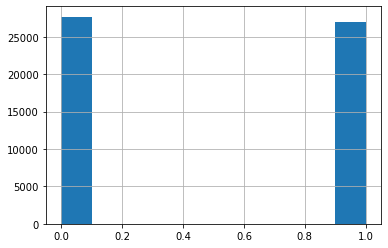

In [28]:
df04['cardio'].hist();

### 4.1.2. Numerical Variable

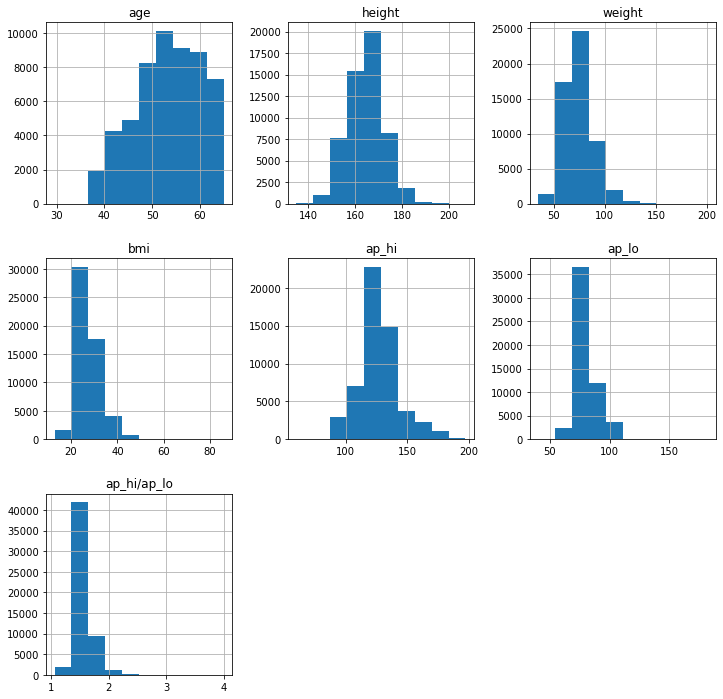

In [29]:
# select numerical attributes
num_attributes = df04[['age', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo', 'ap_hi/ap_lo']]

# display histplot of numerical attributes
num_attributes.hist(figsize=(12,12));

#### 4.1.2.1. Age

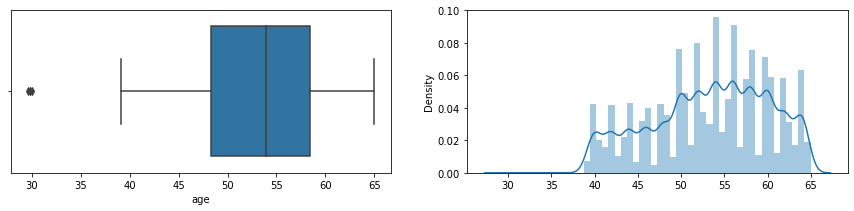

In [30]:
# setup figure size
plt.subplots(figsize=(15,3))

# boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x='age', data=num_attributes);

# distplot
plt.subplot(1, 2, 2)
sns.distplot(x=num_attributes['age']);

#### 4.1.2.2. Height

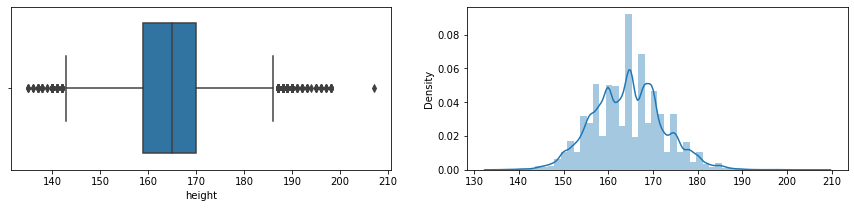

In [31]:
# setup figure size
plt.subplots(figsize=(15,3))

# boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x='height', data=num_attributes);

# distplot
plt.subplot(1, 2, 2)
sns.distplot(x=num_attributes['height']);

#### 4.1.2.3. Weight

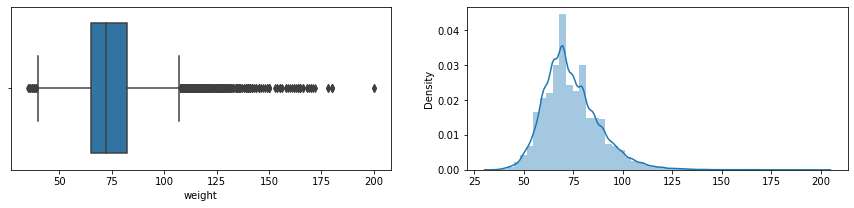

In [32]:
# setup figure size
plt.subplots(figsize=(15,3))

# boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x='weight', data=num_attributes);

# distplot
plt.subplot(1, 2, 2)
sns.distplot(x=num_attributes['weight']);

#### 4.1.2.4. BMI

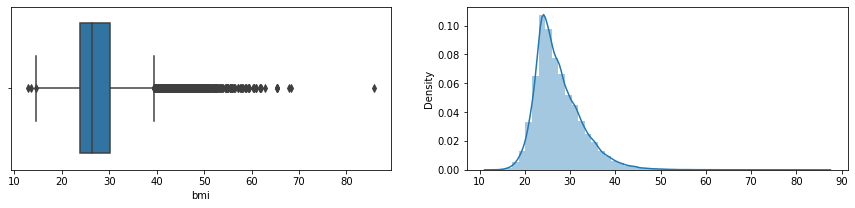

In [33]:
# setup figure size
plt.subplots(figsize=(15,3))

# boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x='bmi', data=num_attributes);

# distplot
plt.subplot(1, 2, 2)
sns.distplot(x=num_attributes['bmi']);

#### 4.1.2.5. Systolic Blood Pressure

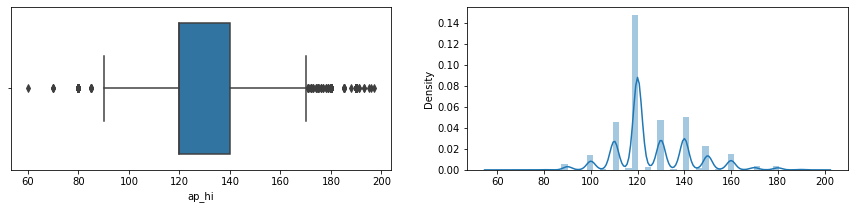

In [34]:
# setup figure size
plt.subplots(figsize=(15,3))

# boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x='ap_hi', data=num_attributes);

# distplot
plt.subplot(1, 2, 2)
sns.distplot(x=num_attributes['ap_hi']);

#### 4.1.2.6. Diastolic Blood Pressure

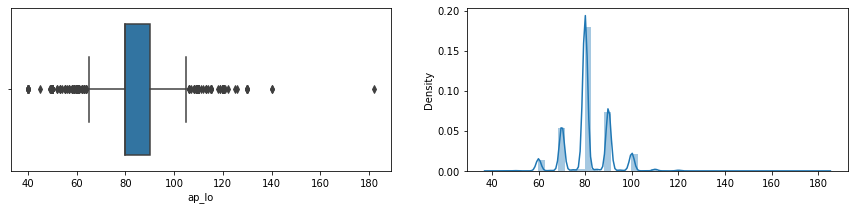

In [35]:
# setup figure size
plt.subplots(figsize=(15,3))

# boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x='ap_lo', data=num_attributes);

# distplot
plt.subplot(1, 2, 2)
sns.distplot(x=num_attributes['ap_lo']);

#### 4.1.2.7. Blood Pressure Ratio

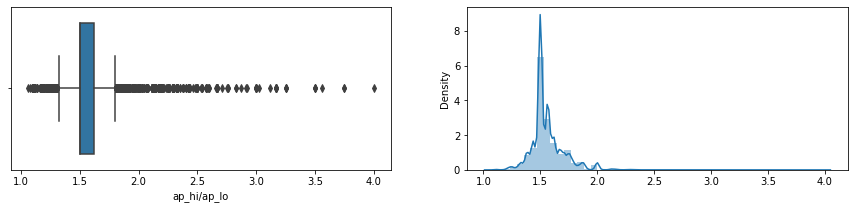

In [36]:
# setup figure size
plt.subplots(figsize=(15,3))

# boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x='ap_hi/ap_lo', data=num_attributes);

# distplot
plt.subplot(1, 2, 2)
sns.distplot(x=num_attributes['ap_hi/ap_lo']);

### 4.1.3. Categorical Variable

In [37]:
# select categorical and binary attributes
cat_attributes = df04[['gender', 'weight_status', 'ap_stages', 'cholesterol', 'gluc', 
                       'smoke', 'alco', 'active', 'bad_habits', 'drink_active']]

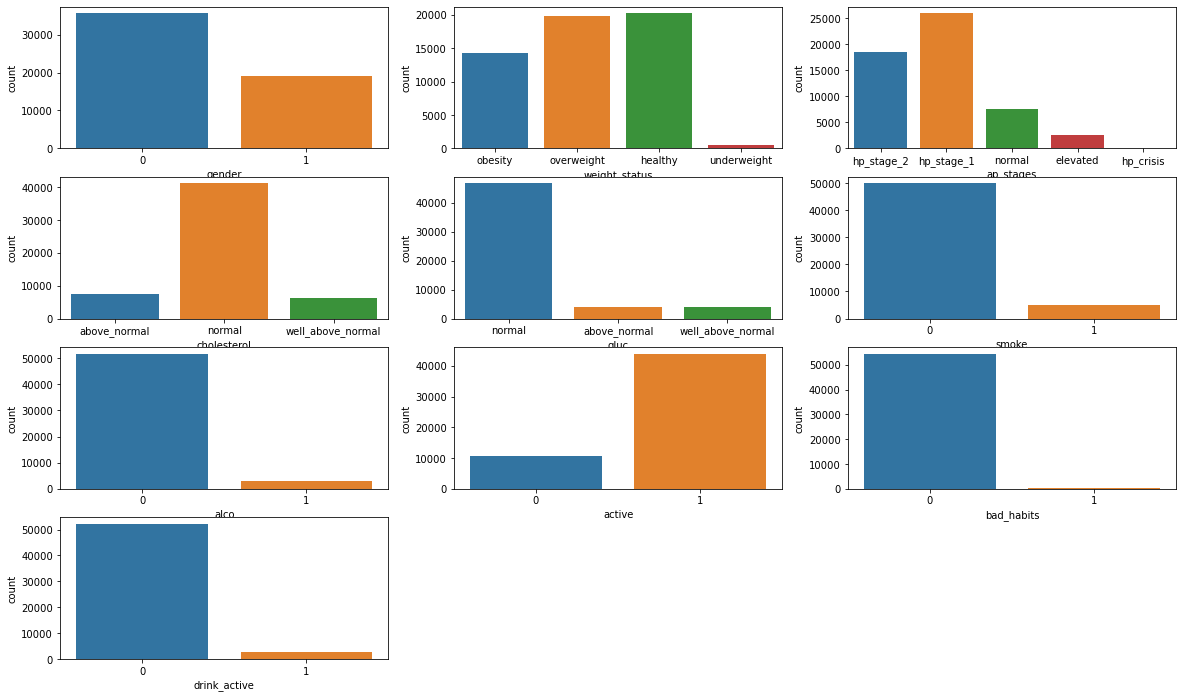

In [38]:
# setup figure size
plt.figure(figsize=(20,12))

# gender
plt.subplot(4, 3, 1)
sns.countplot(x=cat_attributes['gender']);

# weight_status
plt.subplot(4, 3, 2)
sns.countplot(x=cat_attributes['weight_status']);

# ap_stages
plt.subplot(4, 3, 3)
sns.countplot(x=cat_attributes['ap_stages']);

# cholesterol
plt.subplot(4, 3, 4)
sns.countplot(x=cat_attributes['cholesterol']);

# gluc
plt.subplot(4, 3, 5)
sns.countplot(x=cat_attributes['gluc']);

# smoke
plt.subplot(4, 3, 6)
sns.countplot(x=cat_attributes['smoke']);

# alco
plt.subplot(4, 3, 7)
sns.countplot(x=cat_attributes['alco']);

# active
plt.subplot(4, 3, 8)
sns.countplot(x=cat_attributes['active']);

# bad_habits
plt.subplot(4, 3, 9)
sns.countplot(x=cat_attributes['bad_habits']);

# drink_active
plt.subplot(4, 3, 10)
sns.countplot(x=cat_attributes['drink_active']);

## 4.2. Bivariate Analysis

### H1. Both genders have the same proportion of cardiovascular diseases.
**TRUE:** The generos have similar percentages of cardiovascular disease, with variance of 1% between them.

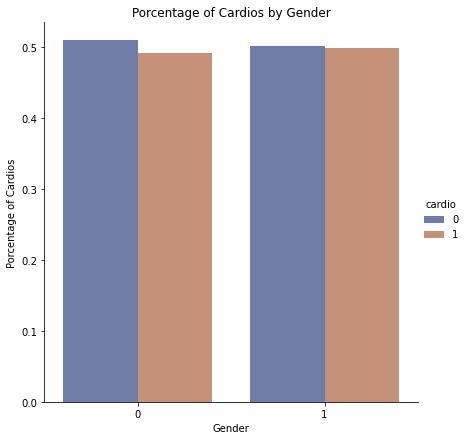

In [39]:
# number of cardios for gender
aux = df04[['gender', 'cardio']].groupby(['gender', 'cardio']).size().reset_index().rename(columns={0: 'cardio_count'})

# percentage of cardios by gender
aux['pct_cardio_by_gender'] = aux[['gender', 'cardio_count']].apply(
                                lambda x: x['cardio_count']/aux[aux['gender'] == x['gender']]['cardio_count'].sum(), 
                                axis=1)
# display graph
graph = sns.catplot(data=aux, kind='bar', x='gender', y='pct_cardio_by_gender', hue='cardio',
                    ci='sd', palette='dark', alpha=.6, height=6);
graph.set_axis_labels('Gender', 'Porcentage of Cardios')
plt.title('Porcentage of Cardios by Gender');

### H2. People over than 40 years old have more than twice as many cardiovascular diseases, on average.
**TRUE:** People over than 40 years old have 2.23 more cardio deseases than younger.

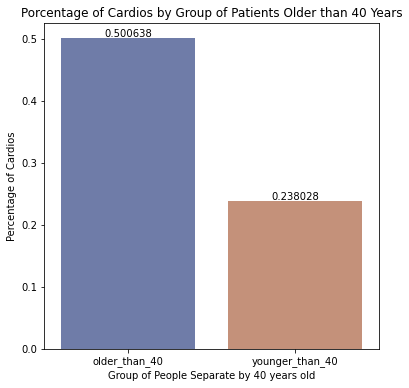

In [40]:
plt.figure(figsize=(6,6))

# select data of interest
aux = df04.loc[:, ['age', 'cardio']]

# separete people older and younger than 40
aux['older_40'] = aux['age'].apply(lambda x: 'older_than_40' if x > 40 else 'younger_than_40')

# calculate de the average of cardios by group of people separate by age
aux1 = aux[['older_40', 'cardio']].groupby('older_40').mean().reset_index()

# display graph
graph = sns.barplot(x='older_40', y='cardio', data=aux1, ci='sd', palette='dark', alpha=.6)
graph.bar_label(graph.containers[0]);
plt.xlabel('Group of People Separate by 40 years old')
plt.ylabel('Percentage of Cardios')
plt.title('Porcentage of Cardios by Group of Patients Older than 40 Years');

### H3. The higher the weight/height ratio, the greater the amount of cardiovascular disease.
**TRUE:** There is a corelation of 0.43 of BMI with the presence of cardiovascular disease.

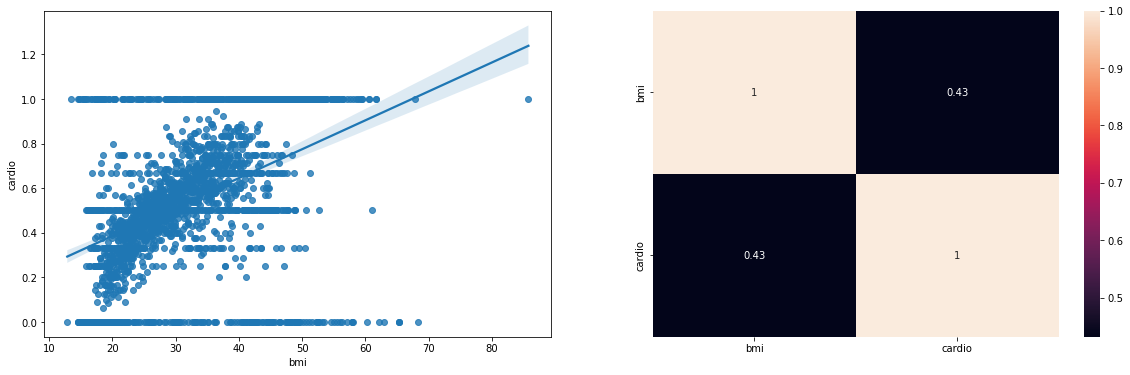

In [41]:
plt.figure(figsize=(20,6))

# average of people with cardio desease grouped by BMI
aux = df04[['bmi', 'cardio']].groupby('bmi').mean().reset_index()

# plot graph of linear regression
plt.subplot(1,2,1)
sns.regplot(x='bmi', y='cardio', data=aux);

# plot graph of correlation between cardios and BMI
plt.subplot(1,2,2)
sns.heatmap(aux.corr( method='pearson'), annot=True);

### H4. Between 40% and 50% of people over than 100kg have cardiovascular disease.
**FALSE:** Almost 70% of people over than 100kg have a cardiovascular disease.

In [42]:
# select data from people over than 100kg
aux = df04[df04['weight'] > 100]

# number of cardios from people over than 100kg
aux1 = aux[['cardio']].groupby('cardio').size().reset_index().rename(columns={0: 'cardio_count'})

# porcentage of cardios 
aux1['pct_cardio'] = aux1['cardio_count']/aux1['cardio_count'].sum()

# display table
aux1

,cardio,cardio_count,pct_cardio
0,0,779,0.318089
1,1,1670,0.681911


### H5. People with heights below 150cm have half as many cardiovascular diseases on average.
**FALSE:** Group of people smaller than 150cm have a similar percentage of cardiac as the larger ones.

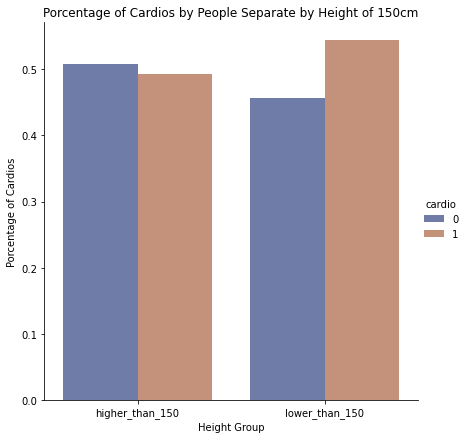

In [43]:
# select data of interest
aux = df04.loc[:, ['height', 'cardio']]

# create a feature separating people by height
aux['below_150'] = aux['height'].apply(lambda x: 'lower_than_150' if x < 150 else 'higher_than_150')

# number of cardios
aux1 = aux[['cardio','below_150']].groupby(['below_150', 'cardio']).size().reset_index().rename(columns={0: 'cardio_count'})

# percentage of cardios for each height group
aux1['pct_cardio'] = aux1[['below_150', 'cardio_count']].apply(
                        lambda x: x['cardio_count']/aux1[aux1['below_150'] == x['below_150']]['cardio_count'].sum(), 
                        axis=1)

# display graph
graph = sns.catplot(data=aux1, kind='bar', x='below_150', y='pct_cardio', hue='cardio',
                    ci='sd', palette='dark', alpha=.6, height=6);
graph.set_axis_labels('Height Group', 'Porcentage of Cardios')
plt.title('Porcentage of Cardios by People Separate by Height of 150cm');

### H6. People with cholesterol well above normal are twice as likely to have cardiovascular disease than people with normal cholesterol, on average.
**FALSE:** People with 'weel above normal' cholesterol have about 75% more cardiovascular disease than people with normal cholesterol

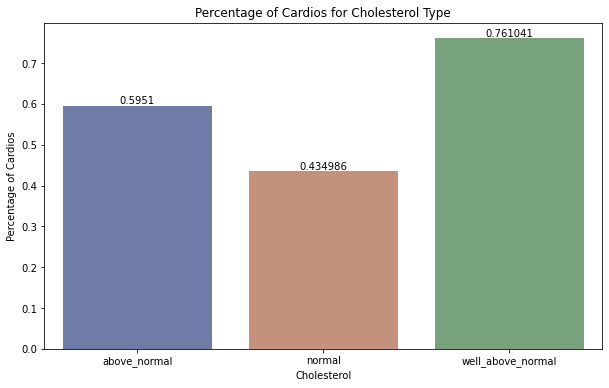

In [44]:
plt.figure(figsize=(10,6))

# average of cardio people by cholesterol status
aux = df04[['cholesterol', 'cardio']].groupby('cholesterol').mean().reset_index()

# display graph
graph = sns.barplot(x='cholesterol', y='cardio', data=aux, ci='sd', palette='dark', alpha=.6);
graph.bar_label(graph.containers[0]);
plt.xlabel('Cholesterol')
plt.ylabel('Percentage of Cardios')
plt.title('Percentage of Cardios for Cholesterol Type');

### H7. Less than 25% of people with normal cholesterol and glucose have cardiovascular disease.
**FALSE:** People with normal cholesterol and glucose have 42% of people with cardiovascular disease.

In [45]:
# select data of interest
aux = df04.loc[(df04['cholesterol'] == 1) & (df04['gluc'] == 1)]

# group cardio people
aux1 = aux[['cardio']].groupby('cardio').size().reset_index().rename(columns={0: 'cardio_count'})

# percentagem of cardios
aux1['pct_cardio'] = aux1['cardio_count']/aux1['cardio_count'].sum()

# display table
aux1

,cardio,cardio_count,pct_cardio


### H8. People with all three glucose levels have a similar percentage (+/-5%) of cardiovascular disease.
**FALSE:** People with higher levels of glucose have a higher percentage of cardiovascular disease.

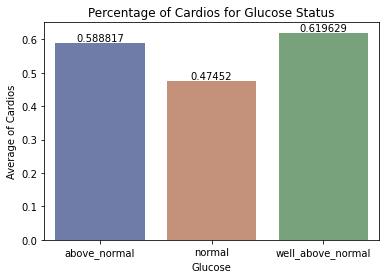

In [46]:
# average of cardios for glucose status
aux = df04[['gluc', 'cardio']].groupby('gluc').mean().reset_index()

# display graph
graph = sns.barplot(x='gluc', y='cardio', data=aux, ci='sd', palette='dark', alpha=.6)
graph.bar_label(graph.containers[0]);
plt.xlabel('Glucose')
plt.ylabel('Average of Cardios')
plt.title('Percentage of Cardios for Glucose Status');

### H9. People with systolic blood pressure above 120 mmHg have 50% more cardiovascular diseases compared to those with pressure below 120 mmHg.
**FALSE:** People with a systolic blood pressure above 120 mmHg have more than twice as many diseases as those below, on average.

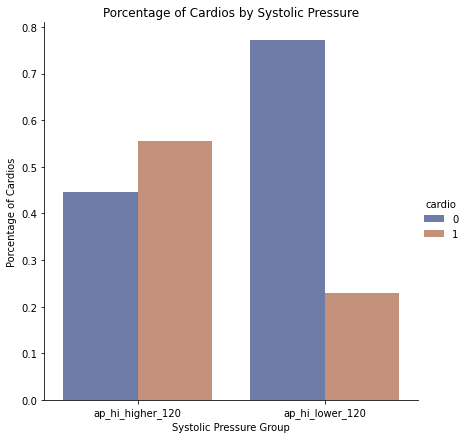

In [47]:
# select data of interest
aux = df04.loc[:, ['ap_hi', 'cardio']]

# create a feature separating people with systolic blood pressure above 120
aux['ap_hi_120'] = aux['ap_hi'].apply(lambda x: 'ap_hi_higher_120' if x >= 120 else 'ap_hi_lower_120')

# number of cardio by systolic blood pressure
aux1 = aux[['ap_hi_120', 'cardio']].groupby(['ap_hi_120', 'cardio']).size().reset_index().rename(columns={0: 'cardio_count'})

# percentage of cardio
aux1['pct_cardio'] = aux1[['ap_hi_120', 'cardio_count']].apply(
                            lambda x: x['cardio_count']/aux1[aux1['ap_hi_120'] == x['ap_hi_120']]['cardio_count'].sum(), 
                            axis=1)

# plot graph
graph = sns.catplot(data=aux1, kind='bar', x='ap_hi_120', y='pct_cardio', hue='cardio',
                    ci='sd', palette='dark', alpha=.6, height=6);
graph.set_axis_labels('Systolic Pressure Group', 'Porcentage of Cardios')
plt.title('Porcentage of Cardios by Systolic Pressure');

### H10. People with a diastolic pressure above 80 mmHg have 50% more cardiovascular diseases compared to those with a pressure below 80 mmHg. 
**FALSE:** People with a diastolic blood pressure above 80 mmHg have almost twice as many diseases as those below, on average.

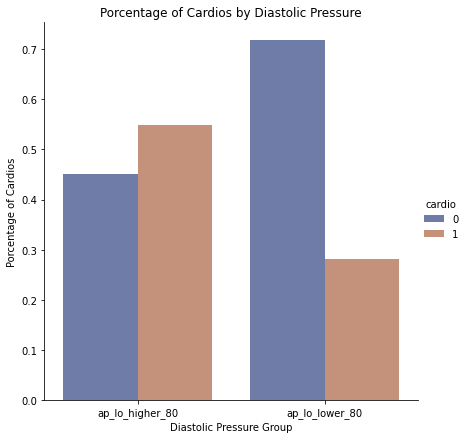

In [48]:
# select data of interest
aux = df04.loc[:, ['ap_lo', 'cardio']]

# create a feature separating people with diastolic blood pressure above 80
aux['ap_lo_80'] = aux['ap_lo'].apply(lambda x: 'ap_lo_higher_80' if x >= 80 else 'ap_lo_lower_80')

# number of cardio by diastolic blood pressure
aux1 = aux[['ap_lo_80', 'cardio']].groupby(['ap_lo_80', 'cardio']).size().reset_index().rename(columns={0: 'cardio_count'})

# percentage of cardio
aux1['pct_cardio'] = aux1[['ap_lo_80', 'cardio_count']].apply(
                            lambda x: x['cardio_count']/aux1[aux1['ap_lo_80'] == x['ap_lo_80']]['cardio_count'].sum(), 
                            axis=1)

# plot graph
graph = sns.catplot(data=aux1, kind='bar', x='ap_lo_80', y='pct_cardio', hue='cardio',
                    ci='sd', palette='dark', alpha=.6, height=6);
graph.set_axis_labels('Diastolic Pressure Group', 'Porcentage of Cardios')
plt.title('Porcentage of Cardios by Diastolic Pressure');

### H11. People with blood pressure (ap_hi / api_lo) higher than 2 have 30% more cardiovascular diseases than those with pressure below. 
**TRUE:** People with blood pressure over 2 have 36% higher presence of cardiovascular disease.

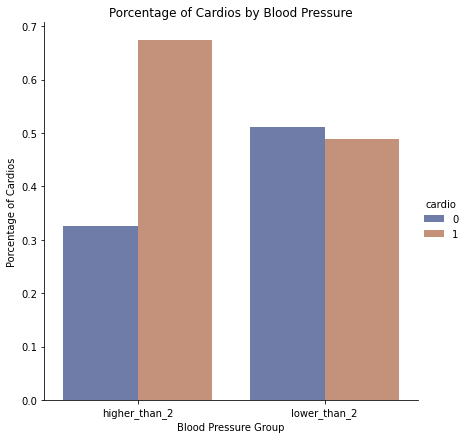

In [49]:
# select data of interest
aux = df04.loc[:, ['ap_hi/ap_lo', 'cardio']]

# create a feature separating people by ap_hi / api_lo
aux['ap_ratio'] = aux['ap_hi/ap_lo'].apply(lambda x: 'higher_than_2' if x >= 2 else 'lower_than_2')

# number of cardio by blood pressure
aux1 = aux[['ap_ratio', 'cardio']].groupby(['ap_ratio', 'cardio']).size().reset_index().rename(columns={0: 'cardio_count'})

# percentage of cardio
aux1['pct_cardio'] = aux1[['ap_ratio', 'cardio_count']].apply(
                            lambda x: x['cardio_count']/aux1[aux1['ap_ratio'] == x['ap_ratio']]['cardio_count'].sum(), 
                            axis=1)

# plot graph
graph = sns.catplot(data=aux1, kind='bar', x='ap_ratio', y='pct_cardio', hue='cardio',
                    ci='sd', palette='dark', alpha=.6, height=6);
graph.set_axis_labels('Blood Pressure Group', 'Porcentage of Cardios')
plt.title('Porcentage of Cardios by Blood Pressure');

### H12. People who drink have 20% less cardiovascular disease, on average.
**FALSE:** Peoples have similar cardio percentages independent of alcoholic habits.

In [50]:
# select data of interest
aux = df04.loc[:, ['alco', 'cardio']]

# average of cardios by alcohol habits
aux1 = aux[['alco', 'cardio']].groupby('alco').mean().reset_index()

# display table
aux1

,alco,cardio
0,0,0.495218
1,1,0.469518


### H13. People who practice physical activity have 30% less cardiovascular disease, on average.
**FALSE:** Peoples have similar cardio percentages independent of be active, with less than 5% of variance.

In [51]:
# select data of interest
aux = df04.loc[:, ['active', 'cardio']]

# average of cardios by active people
aux1 = aux[['active', 'cardio']].groupby('active').mean().reset_index()

# display table
aux1

,active,cardio
0,0,0.528000
1,1,0.485469


### H14. People who smoke, drink, and do not exercise have 3 times more cardiovascular disease on average.
**FALSE:** People with bad health habits have similar percentage of cardios.

In [52]:
# select data of interest
aux = df04.loc[:, ['bad_habits', 'cardio']]

# average of cardios by health habits
aux1 = aux[['bad_habits', 'cardio']].groupby('bad_habits').mean().reset_index()

# display table
aux1

,bad_habits,cardio
0,0,0.493688
1,1,0.526549


### H15. People who smoke have a similar percentage (+/-5%) of cardiovascular diseases compared to those who do not smoke.
**TRUE:** People who smoke have a similar percentage of cardios.

,smoke,cardio,cardio_count,pct_cardio
0,0,0,25106,0.503308
1,0,1,24776,0.496692
2,1,0,2594,0.535729
3,1,1,2248,0.464271


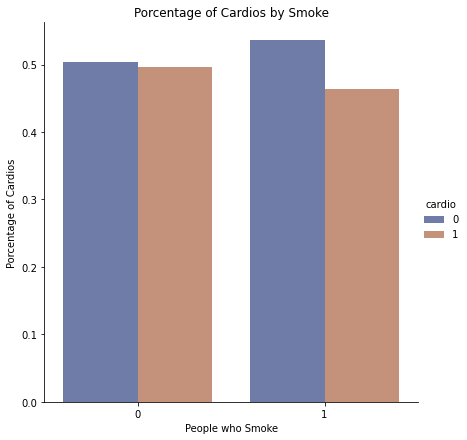

In [53]:
# select data of interest
aux = df04.loc[:, ['smoke', 'cardio']]

# average of cardios by health habits
aux1 = aux[['smoke', 'cardio']].groupby(['smoke', 'cardio']).size().reset_index().rename(columns={0: 'cardio_count'})

# percentage of cardio
aux1['pct_cardio'] = aux1[['smoke', 'cardio_count']].apply(
                            lambda x: x['cardio_count']/aux1[aux1['smoke'] == x['smoke']]['cardio_count'].sum(), 
                            axis=1)

# plot graph
graph = sns.catplot(data=aux1, kind='bar', x='smoke', y='pct_cardio', hue='cardio',
                    ci='sd', palette='dark', alpha=.6, height=6);
graph.set_axis_labels('People who Smoke', 'Porcentage of Cardios')
plt.title('Porcentage of Cardios by Smoke');

# display table
aux1

### H16. People who drink and exercise have 50% less cardiovascular disease compared to those who don't, on average.
**FALSE:** People who drink and exercise have similar percentage of cardiovascular disease.

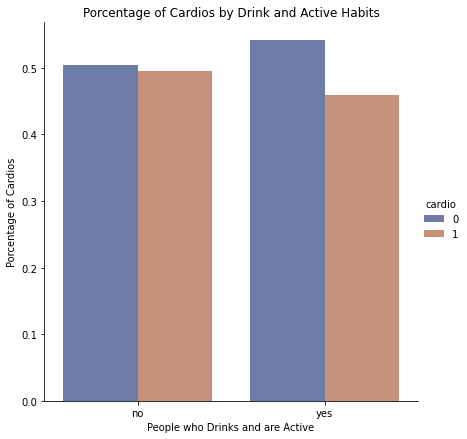

In [54]:
# select data of interest
aux = df04.loc[:, ['alco', 'active', 'cardio']]

# create a feature for people who drink and are active
aux['alco_active'] = aux[['alco', 'active']].apply(lambda x: 'yes' if (x['alco'] == 1) & (x['active'] == 1) else 
                                                             'no', axis=1)

# number of cardio by blood pressure
aux1 = aux[['alco_active', 'cardio']].groupby(['alco_active', 'cardio']).size().reset_index().rename(columns={0: 'cardio_count'})

# percentage of cardio
aux1['pct_cardio'] = aux1[['alco_active', 'cardio_count']].apply(
                            lambda x: x['cardio_count']/aux1[aux1['alco_active'] == x['alco_active']]['cardio_count'].sum(), 
                            axis=1)

# plot graph
graph = sns.catplot(data=aux1, kind='bar', x='alco_active', y='pct_cardio', hue='cardio',
                    ci='sd', palette='dark', alpha=.6, height=6);
graph.set_axis_labels('People who Drinks and are Active', 'Porcentage of Cardios')
plt.title('Porcentage of Cardios by Drink and Active Habits');

### 4.2.1. Hypotheses Summary

In [55]:
# hypothesis description
h1 = "Both genders have the same proportion of cardiovascular diseases."
h2 = "People over than 40 years old have more than twice as many cardiovascular diseases, on average."
h3 = "The higher the weight/height ratio, the greater the amount of cardiovascular disease."
h4 = "Between 40% and 50% of people over than 100kg have cardiovascular disease."
h5 = "People with heights below 150cm have half as many cardiovascular diseases on average."
h6 = "People with cholesterol well above normal are twice as likely to have cardiovascular disease than people with normal cholesterol, on average."
h7 = "Less than 25% of people with normal cholesterol and glucose have cardiovascular disease."
h8 = "People with all three glucose levels have a similar percentage (+/-5%) of cardiovascular disease."
h9 = "People with systolic blood pressure above 120 mmHg have 50% more cardiovascular diseases compared to those with pressure below 120 mmHg."
h10 = "People with a diastolic pressure above 80 mmHg have 50% more cardiovascular diseases compared to those with a pressure below 80 mmHg."
h11 = "People with blood pressure (ap_hi / api_lo) higher than 2 have 30% more cardiovascular diseases than those with pressure below."
h12 = "People who drink have 20% less cardiovascular disease, on average."
h13 = "People who practice physical activity have 30% less cardiovascular disease, on average."
h14 = "People who smoke, drink, and do not exercise have 3 times more cardiovascular disease on average."
h15 = "People who smoke have a similar percentage (+/-5%) of cardiovascular diseases compared to those who do not smoke."
h16 = "People who drink and exercise have 50% less cardiovascular disease compared to those who don't, on average."

# hypothesis results
hip_tab = {'ID': ['H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16'],
           'Hypothesis': [h1, h2, h3, h4, h5, h6, h7, h8, h9, h10, h11, h12, h13, h14, h15, h16],
           'Conclusion': ['True', 'True', 'True', 'False', 'False', 'False', 'False', 'False', 
                          'False', 'False', 'True', 'False', 'False', 'False', 'True', 'False'],
           'Relevance':  ['Low', 'High', 'Medium', 'High', 'Low', 'High', 'Low', 'Medium', 'High', 'High', 
                          'High', 'Low', 'Low', 'Low', 'Low', 'Low']}

# create hypothesis dataframe
df_hyp = pd.DataFrame(hip_tab)

# display hypothesis summary
df_hyp

,ID,Hypothesis,Conclusion,Relevance
0,H1,Both genders have the same proportion of cardi...,True,Low
1,H2,People over than 40 years old have more than t...,True,High
2,H3,"The higher the weight/height ratio, the greate...",True,Medium
3,H4,Between 40% and 50% of people over than 100kg ...,False,High
4,H5,People with heights below 150cm have half as m...,False,Low
5,H6,People with cholesterol well above normal are ...,False,High
6,H7,Less than 25% of people with normal cholestero...,False,Low
7,H8,People with all three glucose levels have a si...,False,Medium
8,H9,People with systolic blood pressure above 120 ...,False,High
9,H10,People with a diastolic pressure above 80 mmHg...,False,High


## 4.3. Multivariate Analysis

In [56]:
# select numeric attributes
num_attributes = df04[['age', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo', 'ap_hi/ap_lo']]

# select binary attributes
bin_attributes = df04[['smoke', 'alco', 'active', 'bad_habits', 'drink_active', 'cardio']]

# select attributes with categorical characteristics
cat_attributes = df04[['gender', 'weight_status', 'ap_stages', 'cholesterol', 'gluc']]

### 4.3.1. Numerical Attributes

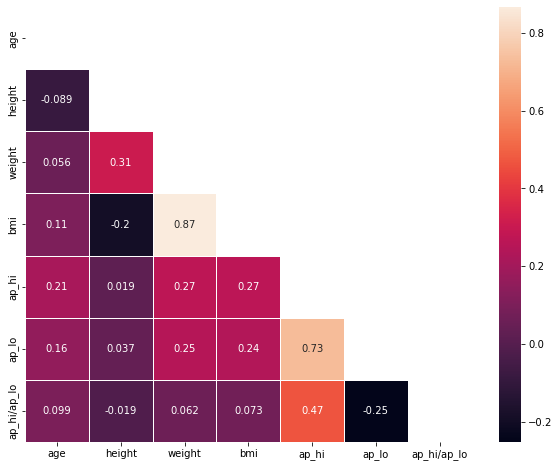

In [57]:
# calculate correlations by pearson
num_corr = num_attributes.corr(method='pearson')

# mask to only show values from below
mask = np.triu(np.ones_like(num_corr, dtype=np.bool_))

# plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(num_corr, mask=mask, linewidths=0.5, annot=True);

### 4.3.2. Binary Attributes

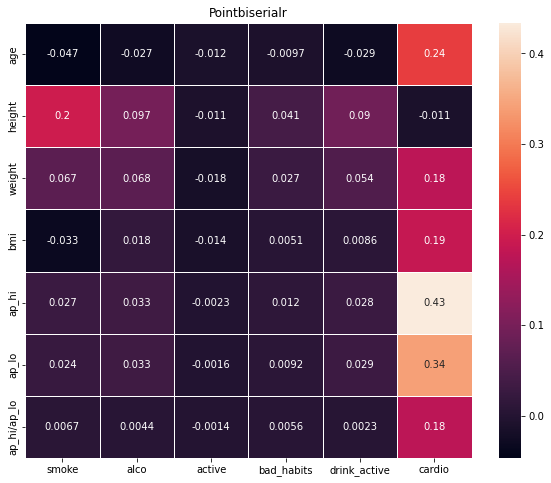

In [58]:
# numeric attributes columns
num_columns = list(num_attributes.columns)

# binary attributes columns
bin_columns = list(bin_attributes.columns)

# empty dict to store point bisserial correlations
bin_correlations = {}

for bin_col in bin_columns:
    # empty list for each binary attribute correlation 
    bin_correlations[bin_col] = []
    
    for num_col in num_columns:
        # calculate point bisserial correlations
        pb = pointbiserialr(bin_attributes[bin_col], num_attributes[num_col])
        
        # store correlation  
        bin_correlations[bin_col].append(pb[0])

# dataset of all point bisserial correlation 
pb_corr = pd.DataFrame(bin_correlations).set_index(num_attributes.columns)


# mask to only show values from below
mask = np.triu(np.ones_like(pb_corr, dtype=np.bool_))

# plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(pb_corr, linewidths=0.5, annot=True);
plt.title("Pointbiserialr");

### 4.3.3. Categorical Attributes

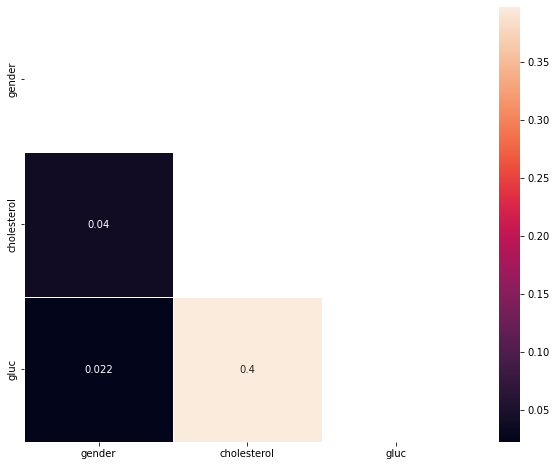

In [59]:
# cramer v of gender
a1 = cramer_v(cat_attributes['gender'], cat_attributes['gender'])
a2 = cramer_v(cat_attributes['gender'], cat_attributes['cholesterol'])
a3 = cramer_v(cat_attributes['gender'], cat_attributes['gluc'])

# cramer v of cholesterol
a4 = cramer_v(cat_attributes['cholesterol'], cat_attributes['gender'])
a5 = cramer_v(cat_attributes['cholesterol'], cat_attributes['cholesterol'])
a6 = cramer_v(cat_attributes['cholesterol'], cat_attributes['gluc'])

# cramer v of glucose
a7 = cramer_v(cat_attributes['gluc'], cat_attributes['gender'])
a8 = cramer_v(cat_attributes['gluc'], cat_attributes['cholesterol'])
a9 = cramer_v(cat_attributes['gluc'], cat_attributes['gluc'])

# dataset of all cramer v correlation 
cat_corr = pd.DataFrame( {'gender': [a1, a2, a3], 
                          'cholesterol': [a4, a5, a6],
                          'gluc': [a7, a8, a9]  })

# set index with columns name
cat_corr = cat_corr.set_index( cat_corr.columns )

# mask to only show values from below
mask = np.triu(np.ones_like(cat_corr, dtype=np.bool_))

# plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(cat_corr, mask=mask, linewidths=0.5, annot=True);

# 5.0. Data Preparation

In [60]:
df05 = df04.copy()

## 5.1. Normalizing

## 5.2. Rescaling

In [61]:
rs = RobustScaler()
mms = MinMaxScaler()

# age - MinMax Scaler
df05['age'] = mms.fit_transform(df05[['age']].values)
# save age scaler object
pickle.dump(mms, open('../parameter/age_scaler.pkl', 'wb'))

# height - Robust Scaler
df05['height'] = rs.fit_transform(df05[['height']].values)
# save height scaler object
pickle.dump(rs, open('../parameter/height_scaler.pkl', 'wb'))

# weight - Robust Scaler
df05['weight'] = rs.fit_transform(df05[['weight']].values)
# save weight scaler object
pickle.dump(rs, open('../parameter/weight_scaler.pkl', 'wb'))

# BMI - MinMax Scaler
df05['bmi'] = mms.fit_transform(df05[['bmi']].values)
# save BMI scaler object
pickle.dump(mms, open('../parameter/bmi_scaler.pkl', 'wb'))

# ap_hi - Robust Scaler
df05['ap_hi'] = rs.fit_transform(df05[['ap_hi']].values)
# save ap_hi scaler object
pickle.dump(rs, open('../parameter/ap_hi_scaler.pkl', 'wb'))

# ap_lo - Robust Scaler
df05['ap_lo'] = rs.fit_transform(df05[['ap_lo']].values)
# save ap_lo scaler object
pickle.dump(rs, open('../parameter/ap_lo_scaler.pkl', 'wb'))

# ap_hi/ap_lo - MinMax Scaler
df05['ap_hi/ap_lo'] = mms.fit_transform(df05[['ap_hi/ap_lo']].values)
# save ap_ratio scaler object
pickle.dump(mms, open('../parameter/ap_ratio_scaler.pkl', 'wb'))

## 5.3. Transformation

### 5.3.1. Encoding

In [62]:
le = LabelEncoder()

In [63]:
# blood pressure category
df05['ap_stages'] = le.fit_transform(df05['ap_stages'])
# save ap_ratio scaler object
pickle.dump(le, open('../parameter/ap_stages_encoder.pkl', 'wb'))

# BMI class
df05['weight_status'] = le.fit_transform(df05['weight_status'])
# save ap_ratio scaler object
pickle.dump(le, open('../parameter/weight_status_encoder.pkl', 'wb'))

# cholesterol
df05['cholesterol'] = le.fit_transform(df05['cholesterol'])
# save ap_ratio scaler object
pickle.dump(le, open('../parameter/cholesterol_encoder.pkl', 'wb'))

# glucose
df05['gluc'] = le.fit_transform(df05['gluc'])
# save ap_ratio scaler object
pickle.dump(le, open('../parameter/gluc_encoder.pkl', 'wb'))

### 5.3.2. Nature Transformation

# 6.0. Feature Selection

In [64]:
df06 = df05.copy()

## 6.1. Split Dataframe into Training and Validation Dataset

In [65]:
# features dataset
X = df06.drop(['cardio'],axis=1)

# response dataset
y = df06['cardio']

In [66]:
# split dataset into training  and validation
X_train, X_val, y_train, y_val = ms.train_test_split(X, y, test_size=0.2, random_state=42)

## 6.2. Manual Selection - Exploratory Data Analysis

In [67]:
manual_selection = ['age', 'weight', 'cholesterol', 'ap_hi', 'ap_lo', 'ap_hi/ap_lo']
# save features select object
pickle.dump(manual_selection, open('../parameter/feat_select_manual.pkl', 'wb'))

# manual selection features
X_train_manual = X_train[manual_selection]
X_val_manual = X_val[manual_selection]

## 6.3. Boruta as Feature Selector

In [68]:
# prepare dataset for Boruta
X_train_n = X_train.values
y_train_n = y_train.values.ravel()

# define Random Forest Regressor
extra_clf = ExtraTreesClassifier(n_jobs=-1)

# define Boruta
boruta = BorutaPy(extra_clf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	11
Iteration: 	9 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	11
Iteration: 	10 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	11
Iteration: 	11 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	11
Iteration: 	12 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	11
Iteration: 	13 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	11
Iteration: 	14 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	11
Iteration: 	15 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	11
Iteration: 	16 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	11
I

In [69]:
# best features from imbalanced dataset
cols_selected = boruta.support_.tolist()
cols_selected_boruta = X_train.iloc[:, cols_selected].columns.to_list()

# check weak features
cols_weak = boruta.support_weak_.tolist()
cols_selected_weak = X_train.iloc[:, cols_weak].columns.to_list()

# not selected features
cols_not_selected_boruta = list(np.setdiff1d(X_train.columns, cols_selected_boruta))

# display best features
cols_selected_boruta
# save features select object
pickle.dump(cols_selected_boruta, open('../parameter/feat_select_boruta.pkl', 'wb'))

### 6.3.1. Attributes Selection as Boruta

In [70]:
# select features by boruta
X_train_boruta = X_train[cols_selected_boruta]
X_val_boruta = X_val[cols_selected_boruta]

## 6.4. PCA - Principal Component Analysis

In [71]:
# define the number of eigenvectors (autovetor) + eigenvalues (autovalores)
pca = decomposition.PCA().fit(X_train)

In [72]:
# return autovalores
pca.explained_variance_ratio_

# accumulated sum of autovalores
np.cumsum(pca.explained_variance_ratio_)

# determine the number of eigenvalues that represents 95% of the variability
k = np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.98)

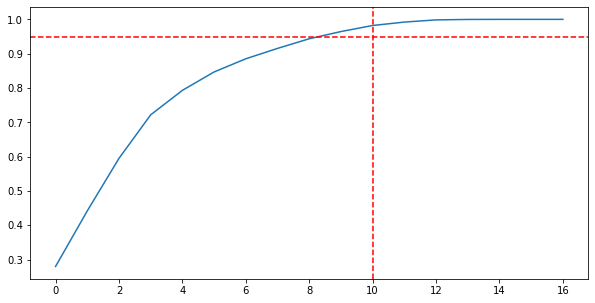

In [73]:
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axvline(k, color='red', linestyle='--')
plt.axhline(0.95, color='red', linestyle='--')

### 6.4.1. Attributes Selection as PCA

In [74]:
# define the number of eigenvectors (autovetor) + eigenvalues (autovalores)
pca = decomposition.PCA().fit( X_train )
k = np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.98)

# change data to new space
pca = decomposition.PCA(k).fit(X_train)
# save features select object
pickle.dump(pca, open('../parameter/feat_select_pca.pkl', 'wb'))

# select features by pca
X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)

## 6.5. Feature Importance - Random Forest

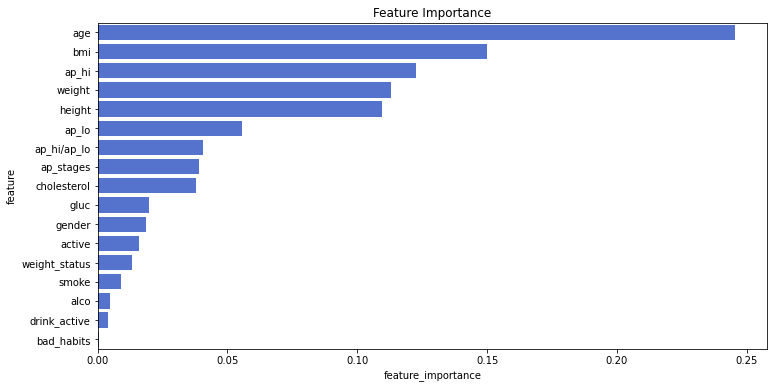

In [75]:
# train random forest classifier
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

# feature importance data frame
feat_imp = pd.DataFrame({'feature': X_train.columns, 'feature_importance': rf.feature_importances_})\
                        .sort_values('feature_importance', ascending=False)\
                        .reset_index(drop=True)

# plot feature importance
plt.subplots(figsize=(12,6))
sns.barplot(x='feature_importance', y='feature', data=feat_imp, orient='h', color='royalblue')\
            .set_title('Feature Importance');

In [76]:
# features importance higher than 0.02
feat_imp_select = feat_imp.loc[feat_imp['feature_importance'] > 0.02]
feat_imp_select

,feature,feature_importance
0,age,0.245663
1,bmi,0.150032
2,ap_hi,0.122639
3,weight,0.113104
4,height,0.109668
5,ap_lo,0.055669
6,ap_hi/ap_lo,0.040430
7,ap_stages,0.038902
8,cholesterol,0.037985


In [77]:
# top features list
feat_list = feat_imp_select['feature'].to_list()
# save features select object
pickle.dump(feat_list, open('../parameter/feat_select_imp.pkl', 'wb'))

# display features select
feat_list

['age',
 'bmi',
 'ap_hi',
 'weight',
 'height',
 'ap_lo',
 'ap_hi/ap_lo',
 'ap_stages',
 'cholesterol']

### 6.5.1. Attributes Selection as Feature Importance

In [78]:
# select features by importance
X_train_feat_imp = X_train[feat_list].copy()
X_val_feat_imp = X_val[feat_list].copy()

# 7.0. Machine Learning Model


**References:**

- Evaluation Metrics for Evaluation Models: https://neptune.ai/blog/evaluation-metrics-binary-classification#:~:text=Simply%20put%20a%20classification%20metric,to%20classes%3A%20positive%20and%20negative.

In [79]:
# select data for machine learning models
x_train = X_train.copy()
x_val = X_val.copy()

# manual feature selection
x_train_manual = X_train_manual.copy()
x_val_manual = X_val_manual.copy()

# boruta feature selection
x_train_boruta = X_train_boruta.copy()
x_val_boruta = X_val_boruta.copy()

# pca feature selection
x_train_pca = X_train_pca.copy()
x_val_pca = X_val_pca.copy()

# importance feature selection
x_train_feat_imp = X_train_feat_imp.copy()
x_val_feat_imp = X_val_feat_imp.copy()

## 7.1. Random Forest Classifier 

In [80]:
# model definition
model_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1).fit(x_train, y_train)

# model definition by manual selection
model_rf_manual = RandomForestClassifier(n_estimators=100, n_jobs=-1).fit(x_train_manual, y_train)

# model definition by boruta
model_rf_boruta = RandomForestClassifier(n_estimators=100, n_jobs=-1).fit(x_train_boruta, y_train)

# model definition by pca
model_rf_pca = RandomForestClassifier(n_estimators=100, n_jobs=-1).fit(x_train_pca, y_train)

# model definition by importance
model_rf_feat_imp = RandomForestClassifier(n_estimators=100, n_jobs=-1).fit(x_train_feat_imp, y_train)

### 7.1.1. Random Forest Classifier - Performance

In [81]:
# prediction
pred_rf = model_rf.predict(x_val)

# evaluate performance of model
rf_performance = pd.DataFrame(['Random Forest Classifier',
                               accuracy_score(y_val, pred_rf), 
                               precision_score(y_val, pred_rf), 
                               recall_score(y_val, pred_rf), 
                               f1_score(y_val, pred_rf),
                               roc_auc_score(y_val, pred_rf)]).T

# set metris as columns name
rf_performance.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

# display performance
rf_performance

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest Classifier,0.716857,0.718171,0.69446,0.706117,0.71641


#### 7.1.1.1. Random Forest Classifier - Performance - Manual Selection

In [82]:
# prediction
pred_rf_manual = model_rf_manual.predict(x_val_manual)

# evaluate performance of model
rf_performance_manual = pd.DataFrame(['Random Forest Classifier - Manual Selection',
                                      accuracy_score(y_val, pred_rf_manual), 
                                      precision_score(y_val, pred_rf_manual), 
                                      recall_score(y_val, pred_rf_manual), 
                                      f1_score(y_val, pred_rf_manual),
                                      roc_auc_score(y_val, pred_rf_manual)]).T

# set metris as columns name
rf_performance_manual.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

# display performance
rf_performance_manual

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest Classifier - Manual Selection,0.673824,0.667102,0.666853,0.666978,0.673684


#### 7.1.1.2. Random Forest Classifier - Performance - Boruta

In [83]:
# prediction
pred_rf_boruta = model_rf_boruta.predict(x_val_boruta)

# evaluate performance of model
rf_performance_boruta = pd.DataFrame(['Random Forest Classifier - Boruta',
                                      accuracy_score(y_val, pred_rf_boruta), 
                                      precision_score(y_val, pred_rf_boruta), 
                                      recall_score(y_val, pred_rf_boruta), 
                                      f1_score(y_val, pred_rf_boruta),
                                      roc_auc_score(y_val, pred_rf_boruta)]).T

# set metris as columns name
rf_performance_boruta.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

# display performance
rf_performance_boruta

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest Classifier - Boruta,0.686067,0.683859,0.667786,0.675727,0.685702


#### 7.1.1.3. Random Forest Classifier - Performance - PCA

In [84]:
# prediction
pred_rf_pca = model_rf_pca.predict(x_val_pca)

# evaluate performance of model
rf_performance_pca = pd.DataFrame(['Random Forest Classifier - PCA',
                                   accuracy_score(y_val, pred_rf_pca), 
                                   precision_score(y_val, pred_rf_pca), 
                                   recall_score(y_val, pred_rf_pca), 
                                   f1_score(y_val, pred_rf_pca),
                                   roc_auc_score(y_val, pred_rf_pca)]).T

# set metris as columns name
rf_performance_pca.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

# display performance
rf_performance_pca

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest Classifier - PCA,0.696665,0.691212,0.688118,0.689662,0.696494


#### 7.1.1.4. Random Forest Classifier - Performance - Feature Importance

In [85]:
# prediction
pred_rf_feat_imp = model_rf_feat_imp.predict(x_val_feat_imp)

# evaluate performance of model
rf_performance_feat_imp = pd.DataFrame(['Random Forest Classifier - Feat. Importance',
                                        accuracy_score(y_val, pred_rf_feat_imp), 
                                        precision_score(y_val, pred_rf_feat_imp), 
                                        recall_score(y_val, pred_rf_feat_imp), 
                                        f1_score(y_val, pred_rf_feat_imp),
                                        roc_auc_score(y_val, pred_rf_feat_imp)]).T

# set metris as columns name
rf_performance_feat_imp.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

# display performance
rf_performance_feat_imp

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest Classifier - Feat. Importance,0.705345,0.70281,0.690356,0.696528,0.705046


#### 7.1.1.5. Random Forest Classifier - Performance Comparative

In [86]:
# performance comparative
comp_performance = pd.concat([rf_performance, 
                              rf_performance_manual, 
                              rf_performance_boruta, 
                              rf_performance_pca, 
                              rf_performance_feat_imp]).reset_index(drop=True)

# display performance for each feature selection
comp_performance.style.highlight_max(color='darkorange')

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest Classifier,0.716857,0.718171,0.694460,0.706117,0.716410
1,Random Forest Classifier - Manual Selection,0.673824,0.667102,0.666853,0.666978,0.673684
2,Random Forest Classifier - Boruta,0.686067,0.683859,0.667786,0.675727,0.685702
3,Random Forest Classifier - PCA,0.696665,0.691212,0.688118,0.689662,0.696494
4,Random Forest Classifier - Feat. Importance,0.705345,0.702810,0.690356,0.696528,0.705046


### 7.1.2. Random Forest Classifier - Cross-Validation

In [87]:
# select metrics of interest
metrics = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')

# cross validation of model
scores  = cross_validate(model_rf, x_train, y_train, scoring=metrics, cv=10)

# cross validation accuracy
acc_cv_mean = np.round(scores['test_accuracy'].mean(), 6)
acc_cv_std = np.round(scores['test_accuracy'].std(), 6)

# cross validation precision
prec_cv_mean = np.round(scores['test_precision'].mean(), 6)
prec_cv_std = np.round(scores['test_precision'].std(), 6)

# cross validation recall
recall_cv_mean = np.round(scores['test_recall'].mean(), 6)
recall_cv_std = np.round(scores['test_recall'].std(), 6)

# cross validation F1 score
f1_score_cv_mean = np.round(scores['test_f1'].mean(), 6)
f1_score_cv_std = np.round(scores['test_f1'].std(), 6)

# cross validation ROC-AUC
roc_auc_cv_mean = np.round(scores['test_roc_auc'].mean(), 6)
roc_auc_cv_std = np.round(scores['test_roc_auc'].std(), 6)

# calculate mean and std and build dataframe for each metric
rf_performance_cv = pd.DataFrame({'Model': 'Random Forest Classifier', 
                                  'Accuracy': f'{acc_cv_mean} +/- {acc_cv_std}', 
                                  'Precision': f'{prec_cv_mean} +/- {prec_cv_std}', 
                                  'Recall': f'{recall_cv_mean} +/- {recall_cv_std}', 
                                  'F1 Score': f'{f1_score_cv_mean} +/- {f1_score_cv_std}', 
                                  'ROC AUC': f'{roc_auc_cv_mean} +/- {roc_auc_cv_std}'}, 
                                 index=[0])

# display model perfomance
rf_performance_cv

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Random Forest Classifier,0.706686 +/- 0.008776,0.709775 +/- 0.007903,0.688871 +/- 0.01349,0.699138 +/- 0.010211,0.76885 +/- 0.00822


#### 7.1.2.1. Random Forest Classifier - Cross-Validation - Manual Selection

In [88]:
# select metrics of interest
metrics = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')

# cross validation of model
scores  = cross_validate(model_rf_manual, x_train_manual, y_train, scoring=metrics, cv=10)

# cross validation accuracy
acc_cv_mean = np.round(scores['test_accuracy'].mean(), 6)
acc_cv_std = np.round(scores['test_accuracy'].std(), 6)

# cross validation precision
prec_cv_mean = np.round(scores['test_precision'].mean(), 6)
prec_cv_std = np.round(scores['test_precision'].std(), 6)

# cross validation recall
recall_cv_mean = np.round(scores['test_recall'].mean(), 6)
recall_cv_std = np.round(scores['test_recall'].std(), 6)

# cross validation F1 score
f1_score_cv_mean = np.round(scores['test_f1'].mean(), 6)
f1_score_cv_std = np.round(scores['test_f1'].std(), 6)

# cross validation ROC-AUC
roc_auc_cv_mean = np.round(scores['test_roc_auc'].mean(), 6)
roc_auc_cv_std = np.round(scores['test_roc_auc'].std(), 6)

# calculate mean and std and build dataframe for each metric
rf_performance_cv_manual = pd.DataFrame({'Model': 'Random Forest Classifier - Manual Selection', 
                                         'Accuracy': f'{acc_cv_mean} +/- {acc_cv_std}', 
                                         'Precision': f'{prec_cv_mean} +/- {prec_cv_std}', 
                                         'Recall': f'{recall_cv_mean} +/- {recall_cv_std}', 
                                         'F1 Score': f'{f1_score_cv_mean} +/- {f1_score_cv_std}', 
                                         'ROC AUC': f'{roc_auc_cv_mean} +/- {roc_auc_cv_std}'}, 
                                        index=[0])

# display model perfomance
rf_performance_cv_manual

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Random Forest Classifier - Manual Selection,0.679892 +/- 0.008532,0.675761 +/- 0.007878,0.678762 +/- 0.014942,0.677202 +/- 0.010132,0.738312 +/- 0.009012


#### 7.1.2.2. Random Forest Classifier - Cross-Validation - Boruta

In [89]:
# select metrics of interest
metrics = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')

# cross validation of model
scores  = cross_validate(model_rf_boruta, x_train_boruta, y_train, scoring=metrics, cv=10)

# cross validation accuracy
acc_cv_mean = np.round(scores['test_accuracy'].mean(), 6)
acc_cv_std = np.round(scores['test_accuracy'].std(), 6)

# cross validation precision
prec_cv_mean = np.round(scores['test_precision'].mean(), 6)
prec_cv_std = np.round(scores['test_precision'].std(), 6)

# cross validation recall
recall_cv_mean = np.round(scores['test_recall'].mean(), 6)
recall_cv_std = np.round(scores['test_recall'].std(), 6)

# cross validation F1 score
f1_score_cv_mean = np.round(scores['test_f1'].mean(), 6)
f1_score_cv_std = np.round(scores['test_f1'].std(), 6)

# cross validation ROC-AUC
roc_auc_cv_mean = np.round(scores['test_roc_auc'].mean(), 6)
roc_auc_cv_std = np.round(scores['test_roc_auc'].std(), 6)

# calculate mean and std and build dataframe for each metric
rf_performance_cv_boruta = pd.DataFrame({'Model': 'Random Forest Classifier - Boruta', 
                                         'Accuracy': f'{acc_cv_mean} +/- {acc_cv_std}', 
                                         'Precision': f'{prec_cv_mean} +/- {prec_cv_std}', 
                                         'Recall': f'{recall_cv_mean} +/- {recall_cv_std}', 
                                         'F1 Score': f'{f1_score_cv_mean} +/- {f1_score_cv_std}', 
                                         'ROC AUC': f'{roc_auc_cv_mean} +/- {roc_auc_cv_std}'}, 
                                        index=[0])

# display model perfomance
rf_performance_cv_boruta

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Random Forest Classifier - Boruta,0.684803 +/- 0.009332,0.686964 +/- 0.007534,0.666713 +/- 0.015946,0.676649 +/- 0.011612,0.746494 +/- 0.008264


#### 7.1.2.3. Random Forest Classifier - Cross-Validation - PCA

In [90]:
# select metrics of interest
metrics = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')

# cross validation of model
scores  = cross_validate(model_rf_pca, x_train_pca, y_train, scoring=metrics, cv=10)

# cross validation accuracy
acc_cv_mean = np.round(scores['test_accuracy'].mean(), 6)
acc_cv_std = np.round(scores['test_accuracy'].std(), 6)

# cross validation precision
prec_cv_mean = np.round(scores['test_precision'].mean(), 6)
prec_cv_std = np.round(scores['test_precision'].std(), 6)

# cross validation recall
recall_cv_mean = np.round(scores['test_recall'].mean(), 6)
recall_cv_std = np.round(scores['test_recall'].std(), 6)

# cross validation F1 score
f1_score_cv_mean = np.round(scores['test_f1'].mean(), 6)
f1_score_cv_std = np.round(scores['test_f1'].std(), 6)

# cross validation ROC-AUC
roc_auc_cv_mean = np.round(scores['test_roc_auc'].mean(), 6)
roc_auc_cv_std = np.round(scores['test_roc_auc'].std(), 6)

# calculate mean and std and build dataframe for each metric
rf_performance_cv_pca = pd.DataFrame({'Model': 'Random Forest Classifier - PCA', 
                                      'Accuracy': f'{acc_cv_mean} +/- {acc_cv_std}', 
                                      'Precision': f'{prec_cv_mean} +/- {prec_cv_std}', 
                                      'Recall': f'{recall_cv_mean} +/- {recall_cv_std}', 
                                      'F1 Score': f'{f1_score_cv_mean} +/- {f1_score_cv_std}', 
                                      'ROC AUC': f'{roc_auc_cv_mean} +/- {roc_auc_cv_std}'}, 
                                     index=[0])

# display model perfomance
rf_performance_cv_pca

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Random Forest Classifier - PCA,0.689486 +/- 0.004097,0.689146 +/- 0.003445,0.67853 +/- 0.007138,0.683787 +/- 0.00501,0.743026 +/- 0.006235


#### 7.1.2.4. Random Forest Classifier - Cross-Validation - Feature Importance

In [91]:
# select metrics of interest
metrics = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')

# cross validation of model
scores  = cross_validate(model_rf_feat_imp, x_train_feat_imp, y_train, scoring=metrics, cv=10)

# cross validation accuracy
acc_cv_mean = np.round(scores['test_accuracy'].mean(), 6)
acc_cv_std = np.round(scores['test_accuracy'].std(), 6)

# cross validation precision
prec_cv_mean = np.round(scores['test_precision'].mean(), 6)
prec_cv_std = np.round(scores['test_precision'].std(), 6)

# cross validation recall
recall_cv_mean = np.round(scores['test_recall'].mean(), 6)
recall_cv_std = np.round(scores['test_recall'].std(), 6)

# cross validation F1 score
f1_score_cv_mean = np.round(scores['test_f1'].mean(), 6)
f1_score_cv_std = np.round(scores['test_f1'].std(), 6)

# cross validation ROC-AUC
roc_auc_cv_mean = np.round(scores['test_roc_auc'].mean(), 6)
roc_auc_cv_std = np.round(scores['test_roc_auc'].std(), 6)

# calculate mean and std and build dataframe for each metric
rf_performance_cv_feat_imp= pd.DataFrame({'Model': 'Random Forest Classifier - Feat. Importance', 
                                          'Accuracy': f'{acc_cv_mean} +/- {acc_cv_std}', 
                                          'Precision': f'{prec_cv_mean} +/- {prec_cv_std}', 
                                          'Recall': f'{recall_cv_mean} +/- {recall_cv_std}', 
                                          'F1 Score': f'{f1_score_cv_mean} +/- {f1_score_cv_std}', 
                                          'ROC AUC': f'{roc_auc_cv_mean} +/- {roc_auc_cv_std}'}, 
                                         index=[0])

# display model perfomance
rf_performance_cv_feat_imp

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Random Forest Classifier - Feat. Importance,0.698394 +/- 0.010162,0.699611 +/- 0.009254,0.684208 +/- 0.0157,0.69178 +/- 0.011803,0.757667 +/- 0.009462


#### 7.1.2.5. Random Forest Classifier - Cross-Validation - Performance Comparative

In [92]:
# performance comparative
comp_performance_cv = pd.concat([rf_performance_cv, 
                                 rf_performance_cv_manual, 
                                 rf_performance_cv_boruta, 
                                 rf_performance_cv_pca, 
                                 rf_performance_cv_feat_imp]).reset_index(drop=True)

# display performance for each feature selection
comp_performance_cv.style.highlight_max(color='darkorange')

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Random Forest Classifier,0.706686 +/- 0.008776,0.709775 +/- 0.007903,0.688871 +/- 0.01349,0.699138 +/- 0.010211,0.76885 +/- 0.00822
1,Random Forest Classifier - Manual Selection,0.679892 +/- 0.008532,0.675761 +/- 0.007878,0.678762 +/- 0.014942,0.677202 +/- 0.010132,0.738312 +/- 0.009012
2,Random Forest Classifier - Boruta,0.684803 +/- 0.009332,0.686964 +/- 0.007534,0.666713 +/- 0.015946,0.676649 +/- 0.011612,0.746494 +/- 0.008264
3,Random Forest Classifier - PCA,0.689486 +/- 0.004097,0.689146 +/- 0.003445,0.67853 +/- 0.007138,0.683787 +/- 0.00501,0.743026 +/- 0.006235
4,Random Forest Classifier - Feat. Importance,0.698394 +/- 0.010162,0.699611 +/- 0.009254,0.684208 +/- 0.0157,0.69178 +/- 0.011803,0.757667 +/- 0.009462


### 7.1.3. Test and Training Evaluation

#### 7.1.3.1. Data Test Preparation

In [93]:
# create a copy of data test
df_test = data_test.copy()

# Data Change
# convert age to years
df_test['age'] = np.round(df_test['age']/365, 2)

# convert gender to binary 
df_test['gender'] = df_test['gender'] - 1

# Feature Engineering
# body mass index (BMI)
df_test['bmi'] =np.round(df_test['weight']/((df_test['height']/100)**2), 2)

# blood pressure ratio (ap_hi/ap_lo)
df_test['ap_hi/ap_lo'] = df_test[['ap_hi', 'ap_lo']].apply(lambda x: np.round(x['ap_hi']/x['ap_lo'], 2) 
                                                                              if x['ap_lo'] != 0 else 0, axis=1 )


# people who smoke, drink and are not active
df_test['bad_habits'] = df_test[['smoke', 'alco', 'active']].apply(lambda x: 1 if (x['smoke'] == 1) & 
                                                                                  (x['alco'] == 1) & 
                                                                                  (x['active'] == 0) else 0, 
                                                                   axis=1)

# people who drink and are active
df_test['drink_active'] = df_test[['alco', 'active']].apply(lambda x: 1 if (x['alco'] == 1) & 
                                                                           (x['active'] ==1) else 0, 
                                                            axis=1)
# weight status based on BMI
df_test['weight_status'] = df_test['bmi'].apply(lambda x: 'underweight' if x < 18.5 else 
                                                          'healthy'     if (x >= 18.5) & (x < 25) else 
                                                          'overweight'  if (x >= 25) & (x < 30) else 
                                                          'obesity')

# blood pressure stages
df_test['ap_stages'] = df_test[['ap_hi', 'ap_lo']].apply(lambda x: 'hp_crisis'  if (x['ap_hi'] > 180) | (x['ap_lo'] > 120) else
                                                                   'hp_stage_2' if (x['ap_hi'] >= 140) | (x['ap_lo'] >= 90) else
                                                                   'hp_stage_1' if (x['ap_hi'] >= 130) | (x['ap_lo'] >= 80) else 
                                                                   'elevated'   if (x['ap_hi'] >= 120) else 
                                                                   'normal', axis=1)

# transformation cholesterol in categorical data
df_test['cholesterol'] = df_test['cholesterol'].apply(lambda x: 'normal' if x == 1 else 
                                                                'above_normal' if x == 2 else 
                                                                'well_above_normal')

# transformation glucose in categorical data
df_test['gluc'] = df_test['gluc'].apply(lambda x: 'normal' if x == 1 else 
                                                  'above_normal' if x == 2 else 
                                                  'well_above_normal')


# # Data Filtering
# select columns
df_test = df_test.drop(['id'], axis=1)


# Rescale
#load scaler
age_scaler = pickle.load(open('../parameter/age_scaler.pkl', 'rb'))
height_scaler = pickle.load(open('../parameter/height_scaler.pkl', 'rb'))
weight_scaler = pickle.load(open('../parameter/weight_scaler.pkl', 'rb'))
bmi_scaler = pickle.load(open('../parameter/bmi_scaler.pkl', 'rb'))
ap_hi_scaler = pickle.load(open('../parameter/ap_hi_scaler.pkl', 'rb'))
ap_lo_scaler = pickle.load(open('../parameter/ap_lo_scaler.pkl', 'rb'))
ap_ratio_scaler = pickle.load(open('../parameter/ap_ratio_scaler.pkl', 'rb'))
ap_stages_encoder = pickle.load(open('../parameter/ap_stages_encoder.pkl', 'rb'))
weight_status_encoder = pickle.load(open('../parameter/weight_status_encoder.pkl', 'rb'))
cholesterol_encoder = pickle.load(open('../parameter/cholesterol_encoder.pkl', 'rb'))
gluc_encoder = pickle.load(open('../parameter/gluc_encoder.pkl', 'rb'))

# rescale 
# age
df_test['age'] = age_scaler.transform(df_test[['age']].values)

# height
df_test['height'] = height_scaler.transform(df_test[['height']].values)

# weight
df_test['weight'] = weight_scaler.transform(df_test[['weight']].values)

# bmi
df_test['bmi'] = bmi_scaler.transform(df_test[['bmi']].values)

# ap_hi
df_test['ap_hi'] = ap_hi_scaler.transform(df_test[['ap_hi']].values)

# ap_lo
df_test['ap_lo'] = ap_lo_scaler.transform(df_test[['ap_lo']].values)

# ap_hi/ap_lo
df_test['ap_hi/ap_lo'] = ap_ratio_scaler.transform(df_test[['ap_hi/ap_lo']].values)

# encoding
# blood pressure category
df_test['ap_stages'] = ap_stages_encoder.transform(df_test[['ap_stages']].values)

# BMI class
df_test['weight_status'] = weight_status_encoder.transform(df_test[['weight_status']].values)

# cholesterol
df_test['cholesterol'] = cholesterol_encoder.transform(df_test[['cholesterol']].values)

# glucose
df_test['gluc'] = gluc_encoder.transform(df_test[['gluc']].values)

In [94]:
df_test.sample(5).T

,27294,41664,58218,26161,42400
age,0.654140,0.520769,0.762362,0.727324,0.913817
gender,1.000000,1.000000,0.000000,1.000000,0.000000
height,0.909091,1.454545,-0.454545,-0.454545,-1.181818
weight,1.647059,2.647059,0.470588,-0.411765,0.764706
ap_hi,0.500000,1.000000,1.000000,0.000000,0.500000
ap_lo,1.000000,1.000000,1.000000,0.000000,-1.000000
cholesterol,2.000000,1.000000,0.000000,1.000000,0.000000
gluc,2.000000,1.000000,1.000000,1.000000,0.000000
smoke,0.000000,0.000000,0.000000,0.000000,0.000000
alco,0.000000,0.000000,0.000000,0.000000,0.000000


In [95]:
# select data for machine learning models
x_test = df_test.drop(['cardio'], axis=1)
y_test = df_test['cardio'].copy()

# manual feature selection
x_test_manual = df_test[manual_selection].copy()

# boruta feature selection
x_test_boruta = df_test[cols_selected_boruta].copy()

# pca feature selection
x_test_pca = pca.transform(x_test)

# importance feature selection
x_test_feat_imp = df_test[feat_list].copy()

#### 7.1.3.2. Data Test Performance

In [96]:
# prediction
pred_rf = model_rf.predict(x_test)

# evaluate performance of model
rf_performance_test = pd.DataFrame(['Random Forest Classifier',
                                    accuracy_score(y_test, pred_rf), 
                                    precision_score(y_test, pred_rf), 
                                    recall_score(y_test, pred_rf), 
                                    f1_score(y_test, pred_rf),
                                    roc_auc_score(y_test, pred_rf)]).T

# set metris as columns name
rf_performance_test.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

# display performance
rf_performance_test

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest Classifier,0.518643,0.512356,0.807188,0.626834,0.518147


In [97]:
# prediction
pred_rf = model_rf_manual.predict(x_test_manual)

# evaluate performance of model
rf_performance_manual_test = pd.DataFrame(['Random Forest Classifier - Manual Selection',
                                           accuracy_score(y_test, pred_rf), 
                                           precision_score(y_test, pred_rf), 
                                           recall_score(y_test, pred_rf), 
                                           f1_score(y_test, pred_rf),
                                           roc_auc_score(y_test, pred_rf)]).T

# set metris as columns name
rf_performance_manual_test.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

# display performance
rf_performance_manual_test

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest Classifier - Manual Selection,0.678429,0.67696,0.684683,0.6808,0.678418


In [98]:
# prediction
pred_rf = model_rf_boruta.predict(x_test_boruta)

# evaluate performance of model
rf_performance_boruta_test = pd.DataFrame(['Random Forest Classifier - Boruta',
                                           accuracy_score(y_test, pred_rf), 
                                           precision_score(y_test, pred_rf), 
                                           recall_score(y_test, pred_rf), 
                                           f1_score(y_test, pred_rf),
                                           roc_auc_score(y_test, pred_rf)]).T

# set metris as columns name
rf_performance_boruta_test.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

# display performance
rf_performance_boruta_test

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest Classifier - Boruta,0.686214,0.691981,0.673132,0.682426,0.686237


In [99]:
# prediction
pred_rf = model_rf_pca.predict(x_test_pca)

# evaluate performance of model
rf_performance_pca_test = pd.DataFrame(['Random Forest Classifier - PCA',
                                        accuracy_score(y_test, pred_rf), 
                                        precision_score(y_test, pred_rf), 
                                        recall_score(y_test, pred_rf), 
                                        f1_score(y_test, pred_rf),
                                        roc_auc_score(y_test, pred_rf)]).T

# set metris as columns name
rf_performance_pca_test.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

# display performance
rf_performance_pca_test

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest Classifier - PCA,0.502429,0.502323,0.709355,0.588152,0.502073


In [100]:
# prediction
pred_rf = model_rf_feat_imp.predict(x_test_feat_imp)

# evaluate performance of model
rf_performance_feat_test = pd.DataFrame(['Random Forest Classifier - Feat. Importance',
                                         accuracy_score(y_test, pred_rf), 
                                         precision_score(y_test, pred_rf), 
                                         recall_score(y_test, pred_rf), 
                                         f1_score(y_test, pred_rf),
                                         roc_auc_score(y_test, pred_rf)]).T

# set metris as columns name
rf_performance_feat_test.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

# display performance
rf_performance_feat_test

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest Classifier - Feat. Importance,0.698286,0.701678,0.691671,0.696639,0.698297


#### 7.1.3.3. Performance Analysis 

In [101]:
feat_selection_perf = pd.concat([rf_performance_test, 
                                 rf_performance_manual_test, 
                                 rf_performance_boruta_test, 
                                 rf_performance_pca_test, 
                                 rf_performance_feat_test]).reset_index(drop=True)

# display performance
feat_selection_perf.style.highlight_max(color='darkorange')

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest Classifier,0.518643,0.512356,0.807188,0.626834,0.518147
1,Random Forest Classifier - Manual Selection,0.678429,0.676960,0.684683,0.680800,0.678418
2,Random Forest Classifier - Boruta,0.686214,0.691981,0.673132,0.682426,0.686237
3,Random Forest Classifier - PCA,0.502429,0.502323,0.709355,0.588152,0.502073
4,Random Forest Classifier - Feat. Importance,0.698286,0.701678,0.691671,0.696639,0.698297


- Evaluating the performance of the models to the test dataset for each feature selection, the selection by feature importance achieved the best metrics and will be adopted for the project.

#### 7.1.3.4. Generalization Capacity Analysis

In [102]:
pd.concat([rf_performance, rf_performance_test]).reset_index(drop=True)

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest Classifier,0.716857,0.718171,0.69446,0.706117,0.71641
1,Random Forest Classifier,0.518643,0.512356,0.807188,0.626834,0.518147


In [103]:
# manual selection
df_manual_over = pd.concat([rf_performance_manual,rf_performance_manual_test]).reset_index(drop=True)

df_manual_over

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest Classifier - Manual Selection,0.673824,0.667102,0.666853,0.666978,0.673684
1,Random Forest Classifier - Manual Selection,0.678429,0.67696,0.684683,0.6808,0.678418


In [104]:
# boruta
df_boruta_over = pd.concat([rf_performance_boruta,rf_performance_boruta_test]).reset_index(drop=True)

df_boruta_over

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest Classifier - Boruta,0.686067,0.683859,0.667786,0.675727,0.685702
1,Random Forest Classifier - Boruta,0.686214,0.691981,0.673132,0.682426,0.686237


In [105]:
# pca
df_pca_over = pd.concat([rf_performance_pca,rf_performance_pca_test]).reset_index(drop=True)

df_pca_over

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest Classifier - PCA,0.696665,0.691212,0.688118,0.689662,0.696494
1,Random Forest Classifier - PCA,0.502429,0.502323,0.709355,0.588152,0.502073


In [107]:
# features importance
df_feat_imp_over = pd.concat([rf_performance_feat_imp,rf_performance_feat_test]).reset_index(drop=True)

df_feat_imp_over

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest Classifier - Feat. Importance,0.705345,0.70281,0.690356,0.696528,0.705046
1,Random Forest Classifier - Feat. Importance,0.698286,0.701678,0.691671,0.696639,0.698297


- Comparing the performances for the training and test datasets, the importance selection presented the closest match between the two results, demonstrating the best generalization ability of the model.